In [1]:
import re
import time
import requests
import bs4
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans

For reuseability and maintenance purposes, we created `.py` file to serve as utility modules for this project. The utility modules should be inside a folder name `utils` which is in the same directory of this supplementary notebook.

Utility modules:
1. `case_retriever` - this module's primary purpose is for the clustering and information retrieval part of the project.
2. `case_scraper` - this module is used in scraping the Supreme Court cases.
3. `vectorizer` - this module is for the vectorization of the cases.

In [148]:
# import utility modules
from utils import case_retriever, case_scraper, vectorizer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Web scraping

The Supreme Court cases used in this study are collected from the <a href="http://elibrary.judiciary.gov.ph/thebookshelf/">Supreme Court E-libarary website</a>. We collected cases from the years 2000 to 2020. These cases are then saved into `sqlite3` databases.

#### Get all cases and their corresponding links

In [5]:
db_path = '/mnt/processed/private/msds2021/lt10/'
db_table = 'supreme_court_2'
db = f'{db_path}supreme_court_part2.db'

# from 2000 to 2020
years = range(2000, 2020)
case_scraper.get_cases(years, db, db_table)

100%|██████████| 20/20 [00:32<00:00,  1.60s/it]


In [6]:
conn = sqlite3.connect(db)
df = pd.read_sql(f'SELECT * from {db_table}', con=conn)
case_links = df['Link'].to_list()

case_scraper.get_case_details(case_links, db, db_table)

100%|██████████| 15210/15210 [00:00<00:00, 1928284.48it/s]


### Reading data from database

The group created two main databases for the Supreme Court cases:

1. `supremo.db` - contains all the details of the Supreme Court cases.
2. `tax_cases.db` - contains all the `tax cases` that are the focused of this study.

In [3]:
db_path = '/mnt/processed/private/msds2021/lt10/'
supremo = 'supremo.db'
taxes = 'tax_cases.db'

#### All cases

In [4]:
conn = sqlite3.connect(db_path + supremo)

In [5]:
df_cases = pd.read_sql("""SELECT * FROM supremo""", con=conn)
df_cases.head()

,index_x,Case no.,Title,Date,Link,index_y,Justice,Text
0,0,A.M. No. MTJ-99-1226,"GLORIA LUCAS, COMPLAINANT, VS. JUDGE AMELIA A....","January 31, 2000",http://elibrary.judiciary.gov.ph/thebookshelf/...,0,"QUISUMBING, J.:","In a verified complaint dated May 20, 1997, co..."
1,1,G.R. Nos. 88521-22,"HEIRS OF EULALIO RAGUA, NAMELY, DOMINGO, MARCI...","JANUARY 31, 2000",http://elibrary.judiciary.gov.ph/thebookshelf/...,0,"PARDO, J.:",These consolidated cases involve a prime lot c...
2,2,G.R. No. 105827,"J.L. BERNARDO CONSTRUCTION, REPRESENTED BY ATT...","January 31, 2000",http://elibrary.judiciary.gov.ph/thebookshelf/...,0,"GONZAGA-REYES, J.:",This petition for certiorari under Rule 65 see...
3,3,G.R. No. 112139,"LAPANDAY AGRICULTURAL DEVELOPMENT CORPORATION,...","January 31, 2000",http://elibrary.judiciary.gov.ph/thebookshelf/...,0,"GONZAGA-REYES, J.:",Before us is a Petition for Review on Certiora...
4,4,G.R. No. 115045,"UNIVERSITY PHYSICIANS SERVICES, INC., petition...","January 31, 2000",http://elibrary.judiciary.gov.ph/thebookshelf/...,0,"GONZAGA-REYES, J.:",Before us is a Petition for Review by way of C...


#### Tax cases

In [6]:
t_conn = sqlite3.connect(db_path + taxes)

In [7]:
tax_cases = pd.read_sql("""SELECT * FROM tax_cases""", con=t_conn)
tax_cases.head()

,Case no.,Title,Date,Link,Justice,Text,Decision,Filed by Government,Win for Petitioner,Modified,Modified Win for Petitioner,Win for Government,Year Released
0,G.R. No. 108067,"cyanamid philippines, inc., petitioner, vs. th...","January 20, 2000",http://elibrary.judiciary.gov.ph/thebookshelf/...,"QUISUMBING, J.:",petitioner disputes the decision of the court ...,"wherefore, the instant petition is denied, and...",0,0,0,0,1,2000
1,G.R. No. 125355,"commissioner of internal revenue, petitioner, ...","March 30, 2000",http://elibrary.judiciary.gov.ph/thebookshelf/...,"PARDO, J.:",what is before the court is a petition for rev...,"wherefore, the court grants the petition and r...",1,1,0,1,1,2000
2,G.R. No. 132929,"commissioner of customs, petitioner, vs. court...","March 27, 2000",http://elibrary.judiciary.gov.ph/thebookshelf/...,"MENDOZA, J.:",the issue for decision in this case is whether...,"wherefore, the decision of the court of appeal...",0,1,0,1,0,2000
3,G.R. No. 123206,"commissioner of internal revenue, petitioner, ...","March 22, 2000",http://elibrary.judiciary.gov.ph/thebookshelf/...,"GONZAGA-REYES, J.:",assailed in this petition for review on certio...,"wherefore, the december 21, 1995 decision of t...",1,0,0,0,0,2000
4,G.R. No. 118176,"protector's services, inc., petitioner, vs. co...","April 12, 2000",http://elibrary.judiciary.gov.ph/thebookshelf/...,"QUISUMBING, J.:",assailed in this petition for review is the de...,"wherefore, the assailed decision of the court ...",0,0,0,0,1,2000


### Generating stopwords

We needed to filter the words in the cases that we need to include for analysis, but `English` stopwords available in `sklearn` are not enough. Court cases contain particular terms that are very common in each case and we want to capture these terms. Hence, we generated our own stopwords.

In [8]:
tax_docs = tax_cases.Text.values.tolist()
vocab = list(set([i for sub_doc in tax_docs 
                  for i in sub_doc.strip().split()]))

In [9]:
tax_stopwords = vectorizer.generate_stopwords(vocab, tax_docs)

In [10]:
stopwords = tax_stopwords[tax_stopwords.idf <= 1.082177].word.tolist()
stopwords[:10]

['the', 'and', 'in', 'to', 'is', 'it', 'of', 'that', 'by', 'for']

In [11]:
stopwords += ['roque', 'san', 'corona', 'powers', 'en', 'banc', 
              'ra', 'da', 'her', 'ca', 'cir', 'rr']

In [59]:
# set stopwords
_ = vectorizer.get_or_set_stopwords(stopwords)

The generation stopwords are based on the paper Automatically Building a Stopword List for an Information Retrieval System <sup><a href="http://terrierteam.dcs.gla.ac.uk/publications/rtlo_DIRpaper.pdf">[1]</a></sup>. We based the stopword generation from the baseline approaches on the paper. Specifically, we utilized the `TFIDF` scores of the words.

After generating the initial stopwords, the team analyzed the stopwords and added some words that we deemed appropriate to include in the stopwords. These added terms are `roque`, `san`, `corona`, `powers`, `en`, `banc`, `ra`, `da`, `her`, `ca`, `cir`, and `rr`.

In [60]:
# get vectorizer and dataframe of vectorized cases
vect, vect_df = vectorizer.get_vectorizer(tax_cases.Text)
vect_df

,able,about,above,absence,absent,abuse,accepted,accord,according,account,...,withheld,withholding,witness,word,writing,written,xxx,yet,zero,zerorated
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.016014,0.0,0.000000,0.000000,0.041678,...,0.0,0.000000,0.000000,0.028009,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,0.000000,0.000000,0.017154,0.043721,0.000000,0.022727,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,0.019957,0.000000,0.015017,0.019137,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.017399,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.009817,0.000000,0.000000,...,0.0,0.000000,0.000000,0.006512,0.0,0.000000,0.144654,0.013998,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.044327,0.020454,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.052028,...,0.0,0.000000,0.000000,0.000000,0.0,0.149024,0.000000,0.028182,0.0,0.0
464,0.018081,0.009730,0.000000,0.078021,0.098691,0.072102,0.0,0.000000,0.008211,0.062550,...,0.0,0.000000,0.610783,0.007882,0.0,0.000000,0.000000,0.008470,0.0,0.0
465,0.015709,0.118355,0.011820,0.030128,0.000000,0.031322,0.0,0.000000,0.071344,0.000000,...,0.0,0.000000,0.169814,0.000000,0.0,0.000000,0.141966,0.014719,0.0,0.0
466,0.000000,0.000000,0.021714,0.018448,0.011668,0.057538,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0


After the stopwords has been finalized, we then proceeded in the vectorization of the cases' bodies. We used `sklearn`'s `TfidfVectorizer` for this part. The vectorization includes lemmatization of tokens with the used of our customer tokenizer and removal of words from out finalized stopwords.

### Clustering

In [61]:
cluster_range = case_retriever.cluster_range(vect_df.to_numpy(), 
                                             KMeans(random_state=1337), 2, 11)

100%|██████████| 10/10 [05:43<00:00, 34.32s/it]


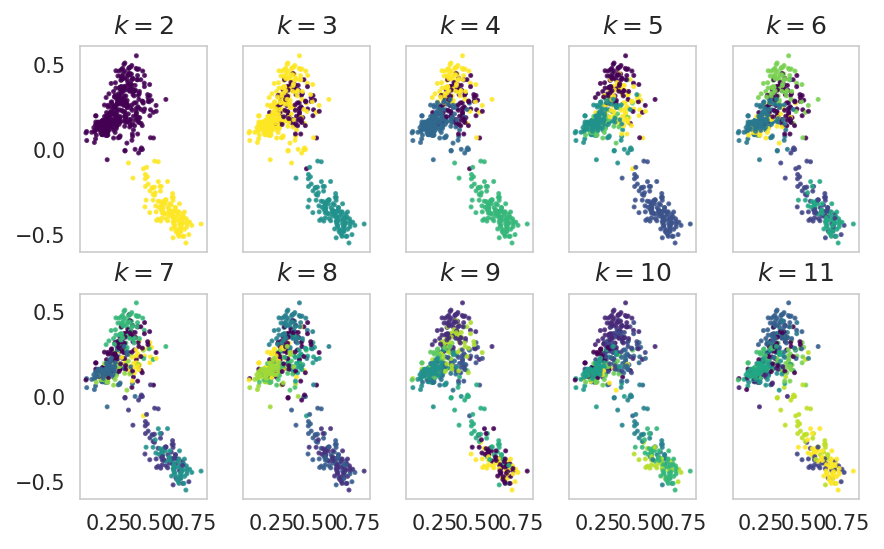

In [62]:
trunc_svd = TruncatedSVD(n_components=2, random_state=1337)
trunc_vals = trunc_svd.fit_transform(vect_df)
case_retriever.plot_clusters(trunc_vals, cluster_range['ys']);

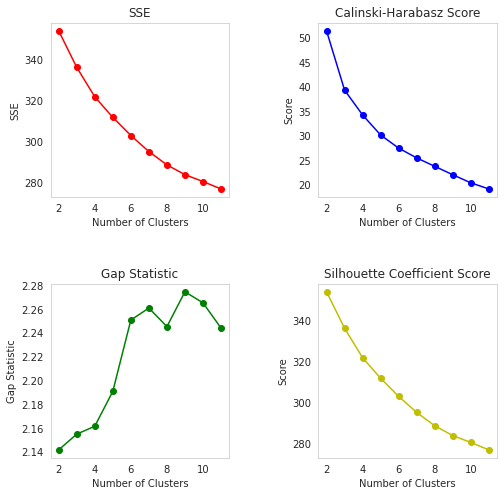

In [63]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
ax[0][0].plot(np.arange(2, 12), cluster_range['inertias'], 'or-')
ax[0][0].set_xlabel('Number of Clusters')
ax[0][0].set_ylabel('SSE')
ax[0][0].set_title('SSE')

ax[0][1].plot(np.arange(2, 12), cluster_range['chs'], 'ob-')
ax[0][1].set_xlabel('Number of Clusters')
ax[0][1].set_ylabel('Score')
ax[0][1].set_title('Calinski-Harabasz Score')

ax[1][0].plot(np.arange(2, 12), cluster_range['gss'], 'og-')
ax[1][0].set_xlabel('Number of Clusters')
ax[1][0].set_ylabel('Gap Statistic')
ax[1][0].set_title('Gap Statistic')

ax[1][1].plot(np.arange(2, 12), cluster_range['inertias'], 'oy-')
ax[1][1].set_xlabel('Number of Clusters')
ax[1][1].set_ylabel('Score')
ax[1][1].set_title('Silhouette Coefficient Score')

plt.show()

#### Concentrating on k=4

In [64]:
trunc_svd = TruncatedSVD(n_components=3, random_state=1337)
trunc_vals = trunc_svd.fit_transform(vect_df)

In [65]:
kmeans = KMeans(n_clusters=4, random_state=1337)
y_predict = kmeans.fit_predict(vect_df)
cluster_centers = kmeans.cluster_centers_

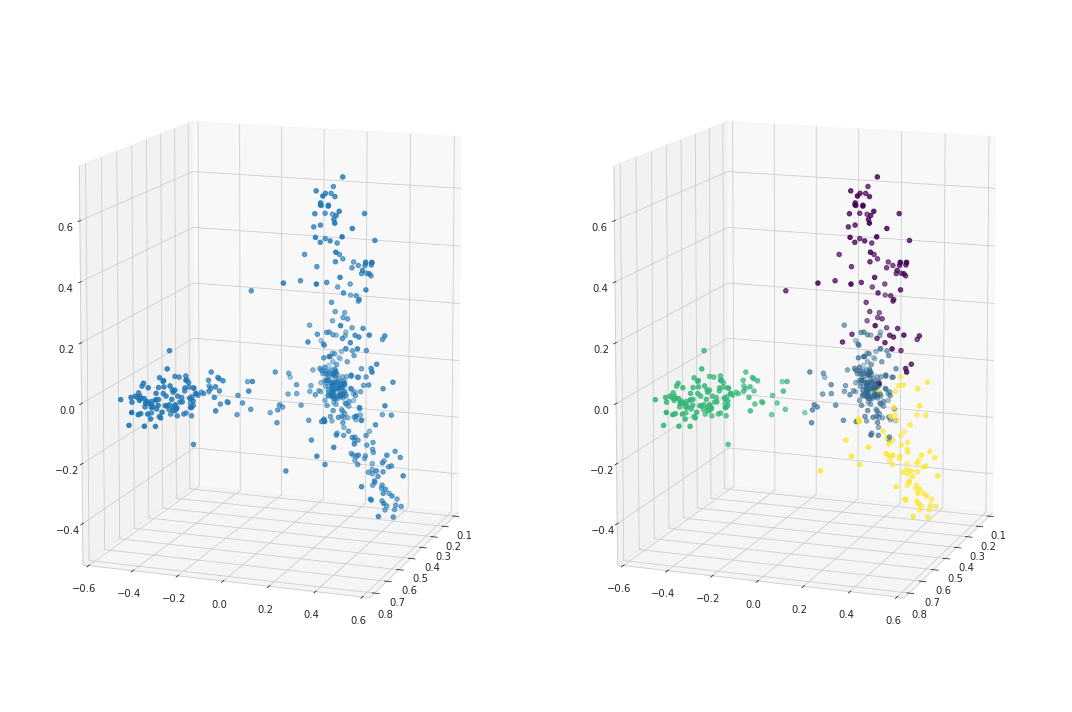

In [66]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(121, projection='3d')
# ax1 = Axes3D(fig)
ax1.scatter(trunc_vals[:, 0], 
           trunc_vals[:, 1],
           trunc_vals[:, 2], 
           marker='o', cmap='viridis')
ax1.view_init(10, 20)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(trunc_vals[:, 0], 
           trunc_vals[:, 1],
           trunc_vals[:, 2], 
           c=y_predict, 
           marker='o', cmap='viridis')
ax2.view_init(10, 20)

plt.tight_layout()
plt.show()

In [67]:
tax_cases['Clusters'] = y_predict
tax_cases['Centroids'] = tax_cases.Clusters.apply(lambda x: cluster_centers[x])
tax_cases.head(2)

,Case no.,Title,Date,Link,Justice,Text,Decision,Filed by Government,Win for Petitioner,Modified,Modified Win for Petitioner,Win for Government,Year Released,Clusters,Centroids
0,G.R. No. 108067,"cyanamid philippines, inc., petitioner, vs. th...","January 20, 2000",http://elibrary.judiciary.gov.ph/thebookshelf/...,"QUISUMBING, J.:",petitioner disputes the decision of the court ...,"wherefore, the instant petition is denied, and...",0,0,0,0,1,2000,1,"[0.006797395747218003, 0.010621542710470031, 0..."
1,G.R. No. 125355,"commissioner of internal revenue, petitioner, ...","March 30, 2000",http://elibrary.judiciary.gov.ph/thebookshelf/...,"PARDO, J.:",what is before the court is a petition for rev...,"wherefore, the court grants the petition and r...",1,1,0,1,1,2000,1,"[0.006797395747218003, 0.010621542710470031, 0..."


In [68]:
tax_cases.groupby('Clusters').size()

Clusters
0     88
1    180
2    123
3     77
dtype: int64

#### Check top words in each cluster

In [71]:
# n_clusters = 4
terms = vect.get_feature_names()
n_clusters = 4
word_df = []
for i in range(n_clusters):
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, 
                          reverse=True)
    word_df.append(sorted_terms[:20])

df_summary = pd.DataFrame(word_df, 
                          columns=['1st','2nd','3rd','4th','5th',
                                   '6th','7th','8th','9th','10th', 
                                   '11th','12th', '13th', '14th', '15th',
                                   '16th', '17th', '18th', '19th', '20th']).T
df_summary.columns =['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3']
df_summary

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
1st,income,excise,vat,assessment
2nd,credit,product,input,deficiency
3rd,withholding,criminal,zerorated,notice
4th,withheld,stamp,credit,letter
5th,excess,trial,judicial,protest
6th,gross,petitioner,quarter,withholding
7th,creditable,custom,invoice,income
8th,option,exemption,good,collection
9th,succeeding,jurisdiction,unutilized,prescription
10th,bank,assessment,mandatory,request


### Case Retrieval Performance Evaluation

In [142]:
objects = vect_df.copy()
all_labels = tax_cases['Clusters'].values
query_case = tax_cases.iloc[0]
query_doc = query_case.Text
query = vectorizer.vectorize_doc(vect, [query_doc])

In [143]:
case_retriever.closest_euc(query.toarray(), objects, 
                           query_case.Clusters, all_labels)

([0, 418, 364, 167, 6, 64, 304, 222, 347, 348], 0.3, 0.016666666666666666)

In [144]:
case_retriever.compute_auc_euc(query.toarray(), objects, 
                               query_case.Clusters, euclidean, all_labels)

0.31603087323995055

#### Norm Table: AUC Means

In [145]:
def get_auc_mean(dist):
    auc_list = []
    for i in range(objects.shape[0]):
        query_case = tax_cases.iloc[i]
        query_doc = query_case.Text
        query = vectorizer.vectorize_doc(vect, [query_doc])
        auc_list.append(case_retriever.compute_auc_euc(query.toarray(), 
                                                       objects, 
                                                       query_case.Clusters, 
                                                       dist,
                                                       all_labels))
    return np.mean(auc_list)

In [147]:
distance_metrics = [euclidean, cityblock, cosine]
dnames = ["euclidean", "cityblock", "cosine"]
auc_dict = {}
for name, i in tqdm(zip(dnames, distance_metrics)):
    auc_dict.setdefault(name, get_auc_mean(i))
auc_dict

3it [01:27, 29.01s/it]


{'euclidean': 0.7447526663413334,
 'cityblock': 0.5783988795284807,
 'cosine': 0.7447526663413334}

### References

[1] Rachel Tsz-Wai Lo, Ben He, Iadh Ounis, Automatically Building a Stopword List for an Information Retrieval System. [downloaded from] http://terrierteam.dcs.gla.ac.uk/publications/rtlo_DIRpaper.pdf [Last access: August 16, 2020]